Example of runnning CBM iteratively. CBM is run for several intervals with an opportunity to adjust disturbance events between each interval.  

The script creates a seperate CBM-CFS3 project for each simulation interval and injects the previous simulation state into each subsequent interation.

Each interval's CBM-CFS3 project has varying disturbance levels, in this case the script sets the harvest C target to be 5% of each previous iteration's end-of-interval total biomass C.

In [14]:
import sys, os, json, subprocess
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [15]:
import sit_helper
standard_import_tool_plugin_path=sit_helper.load_standard_import_tool_plugin()
import cbm3_python_helper
cbm3_python_helper.load_cbm3_python()

import cbm3_python.simulation.projectsimulator
from cbm3_python.cbm3data import cbm3_results
from cbm3_python.cbm3data.aidb import AIDB
from cbm3_python.cbm3data.accessdb import AccessDB
from cbm3_python.cbm3data.projectdb import ProjectDB
from cbm3_python.simulation.simulator import Simulator
from cbm3_python.cbm3data import cbm3_results

In [16]:
local_working_dir = os.path.abspath(".")
toolbox_path = r'C:\Program Files (x86)\Operational-Scale CBM-CFS3'
aidb_path=os.path.join(toolbox_path, "admin", "dbs", "ArchiveIndex_Beta_Install.mdb")
cbm_exe_path=os.path.join(toolbox_path, "admin", "executables")
cbm_wd = os.path.join(toolbox_path, "temp")

#the number of steps in each iteration
iteration_steps = 10
num_iterations = 5

The following methods inject disturbances and transition rules into the iteration import function.

In [17]:
def create_event_factory(events):
    def factory(config):
        for e in events:
            config.add_event(**e)
    return factory
            
def create_transition_rule_factory(transitions):
    def factory(config):
        for t in transitions:
            config.add_transition_rule(**t)
    return factory

Updates the number of timesteps to run for the given CBM project (AccessDB instance)

In [35]:
def set_project_run_length(proj, n_steps):
    proj.ExecuteQuery("UPDATE tblRunTableDetails SET tblRunTableDetails.RunLength = ?", n_steps)

Path helper functions

In [33]:
def get_project_path(iteration_num):
    return os.path.join(local_working_dir, "iterative_cbm", "iterative_cbm_{}.mdb".format(iteration_num))

def get_results_db_path(iteration_num):
    return os.path.join(local_working_dir, "iterative_cbm", "iterative_cbm_results_{}.mdb".format(iteration_num))

def get_config_save_path(iteration_num):
    return os.path.join(local_working_dir, "iterative_cbm", "iterative_cbm_config_{}.json".format(iteration_num))

def get_iteration_tempfiles_dir(iteration_num):
    return os.path.join(local_working_dir, "iterative_cbm", "iterative_cbm_tempfiles_{}".format(iteration_num))

Sets up and imports a constant SIT inventory with varying events and transition rules at the specified path

In [18]:
def iteration_import(project_path, config_save_path, events_factory, transition_factory):


    c = sit_helper.SITConfig(
        imported_project_path=project_path,
        initialize_mapping=True
    )
    c.data_config(
        age_class_size=5,
        num_age_classes=14,
        classifiers=["Stand ID", "Leading Species", "Land Cover"])

    c.set_single_spatial_unit(17)
    c.set_species_classifier("Leading Species")
    c.map_species("Nonforest", "Not stocked")

    c.add_inventory(classifier_set=["Stand 1", "Luvisolic (E. Canada)", "Nonforest"],
                    area=100, age=0, unfccc_land_class=1)
    c.add_inventory(classifier_set=["Stand 2", "Spruce", "Forest Only"],
                    area=1000, age=0, unfccc_land_class=0,
                    historic_disturbance="Wildfire", last_pass_disturbance="Wildfire")

    growth_curve_data = [0,0,0,27,84,155,217,271,317,353,382,406,426,426]

    not_stocked_growth = [0.0]*len(growth_curve_data)

    c.add_yield(classifier_set=["?","?","Nonforest"],
                leading_species_classifier_value="Not stocked",
                values=not_stocked_growth)

    c.add_yield(classifier_set=["?","Red pine","Forest Only"], 
                leading_species_classifier_value="Red pine", values=growth_curve_data)
    
    c.add_yield(classifier_set=["?","Spruce","Forest Only"], 
                leading_species_classifier_value="Spruce", values=growth_curve_data)
    
    events_factory(c)
    transition_factory(c)
    
    c.import_project(standard_import_tool_plugin_path, config_save_path)

    

Set up the first iteration.  This differs from the subsequent iterations in that the stand initialization routines (Makelist) is run to estimate initial forest conditions


In [20]:
events = [
    {
    "classifier_set": ["?","?","?"],
    "disturbance_type": "Afforestation", 
    "time_step": 1, 
    "target": 100,
    "target_type": "Area",
    "sort": "SORT_BY_SW_AGE"
    }
]
transitions = [
    {
    "classifier_set_source": ["?","?","?"],
    "classifier_set_target": ["?","Red pine","Forest Only"],
    "disturbance_type": "Afforestation",
    "percent": 100
    }
]

iteration_num = 1
project_path = get_project_path(iteration_num)
tempfiles_dir = get_iteration_tempfiles_dir(iteration_num)
results_db_path = get_results_db_path(iteration_num)

iteration_import(
    project_path,
    get_config_save_path(iteration_num),
    create_event_factory(events),
    create_transition_rule_factory(transitions))

In [21]:
with AIDB(aidb_path, False) as aidb, \
     AccessDB(project_path, False) as proj:

    proj.ExecuteQuery("UPDATE tblRunTableDetails SET tblRunTableDetails.RunLength = ?", iteration_steps)
    simId = aidb.AddProjectToAIDB(proj)
    s = Simulator(cbm_exe_path,
                simId,
                os.path.dirname(project_path),
                cbm_wd,
                toolbox_path)
    

    s.CleanupRunDirectory()
    s.CreateMakelistFiles()
    s.copyMakelist()
    s.runMakelist()
    s.loadMakelistSVLS()
    s.DumpMakelistSVLs()
    s.CreateCBMFiles()
    s.CopyCBMExecutable()
    s.RunCBM()
    s.CopyTempFiles(output_dir=tempfiles_dir)
    s.LoadCBMResults(output_path = results_db_path)

now run subsequent iterations

In [22]:

for i in range(2,num_iterations+1):
    iteration_num = i
    project_path = get_project_path(iteration_num)
    tempfiles_dir = get_iteration_tempfiles_dir(iteration_num)
    results_db_path = get_results_db_path(iteration_num)

    #get the total biomass from a previous iteration
    total_biomass = cbm3_results.load_pool_indicators( get_results_db_path(i-1))["Total Biomass"][-1:].values[0]
    #set the target to 5% of the total biomass from the previous iteration
    targetC = total_biomass * 0.05
    
    #create a series of events (divided by the number of iterations)
    events = [
        {
        "classifier_set": ["?","?","?"],
        "disturbance_type": "Clear-cut with slash-burn", 
        "time_step": x+1, 
        "target": targetC/iteration_steps,
        "target_type": "Merchantable",
        "sort": "MERCHCSORT_TOTAL"
        } for x in range(iteration_steps)
    ]
    
    #import the project with new disturbance events
    iteration_import(
        project_path,
        get_config_save_path(iteration_num),
        create_event_factory(events),
        create_transition_rule_factory([]))
    
    with AIDB(aidb_path, False) as aidb, \
         AccessDB(project_path, False) as proj:

        proj.ExecuteQuery("UPDATE tblRunTableDetails SET tblRunTableDetails.RunLength = ?", iteration_steps)
        simId = aidb.AddProjectToAIDB(proj)
        s = Simulator(cbm_exe_path,
                    simId,
                    os.path.dirname(project_path),
                    cbm_wd,
                    toolbox_path)

        s.CleanupRunDirectory()
        s.CopyToWorkingDir(project_path)
        s.CreateCBMFiles()
        s.CopyCBMExecutable()
        s.CopySVLFromPreviousRun(os.path.join(get_iteration_tempfiles_dir(i-1),"CBMRun","output"))
        s.RunCBM()
        s.CopyTempFiles(output_dir=tempfiles_dir)
        s.LoadCBMResults(output_path = results_db_path)
   

In [20]:
cbm3_results.load_pool_indicators( get_results_db_path(1))["Total Biomass"]
    

0         0.000000
1       102.647662
2       448.064649
3      1059.966821
4      1950.202115
5      3125.129825
6      4587.288546
7      6336.124666
8      8368.397713
9     10678.445329
10    13258.388015
Name: Total Biomass, dtype: float64

In [21]:
cbm3_results.load_pool_indicators( get_results_db_path(2))["Total Biomass"]
    

0     13258.388015
1     15870.037772
2     18700.057113
3     21739.095879
4     24976.093121
5     28398.448142
6     31992.228490
7     35742.345809
8     39632.765489
9     43646.694767
10    47766.763791
Name: Total Biomass, dtype: float64

In [22]:
cbm3_results.load_pool_indicators( get_results_db_path(3))["Total Biomass"]

0     47766.787352
1     51521.964713
2     55938.368270
3     60370.196450
4     64739.261456
5     69057.337236
6     72761.777134
7     76444.654909
8     80111.098436
9     83765.450936
10    87411.318724
Name: Total Biomass, dtype: float64

In [25]:
cbm3_results.load_pool_indicators( get_results_db_path(4))["Total Biomass"]

0      87411.282227
1      90128.364414
2      92845.063875
3      95562.269379
4      98280.003903
5     100998.874596
6     103264.381427
7     105531.377913
8     107802.002989
9     110077.991017
10    112360.848815
Name: Total Biomass, dtype: float64

In [26]:
cbm3_results.load_pool_indicators( get_results_db_path(5))["Total Biomass"]

0     112360.804630
1     113846.509644
2     115341.880884
3     116848.609563
4     118345.113961
5     119832.527453
6     120979.550064
7     122195.949134
8     123431.935018
9     124675.654521
10    125928.708735
Name: Total Biomass, dtype: float64

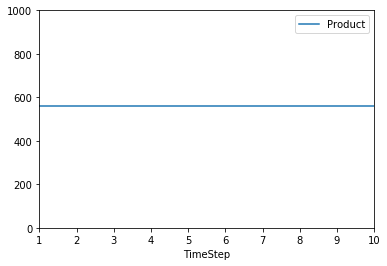

In [32]:
dist_indicators = cbm3_results.load_disturbance_indicators(
    get_results_db_path(5), 
    disturbance_type_grouping=True)

p = dist_indicators.loc[dist_indicators["DistTypeID"]==2][["TimeStep","Product"]].groupby("TimeStep").sum()
p.plot(ylim=(0,1000))